In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [24]:
res_1_df = pd.read_csv('results_1.1.csv')

In [25]:
res_1_df.head()

,degree,threads,time_alloc,time_init,time_seq_baseline,time_thread_create,time_compute,time_thread_join,time_cleanup,time_total,user
0,5000,sequential,0.000018,0.000445,0.014747,0.000000,0.000000,0.000000,0.000001,0.015211,marr
1,5000,1,0.000027,0.000123,0.000000,0.003673,0.039663,0.006640,0.000000,0.050126,marr
2,5000,2,0.000034,0.000118,0.000000,0.005314,0.022167,0.000008,0.000001,0.027642,marr
3,5000,4,0.000054,0.000283,0.000000,0.022847,0.004852,0.000025,0.000001,0.028063,marr
4,5000,8,0.000080,0.000117,0.000000,0.013562,0.026663,0.000034,0.000000,0.040456,marr


In [26]:
os.makedirs('plots', exist_ok=True)

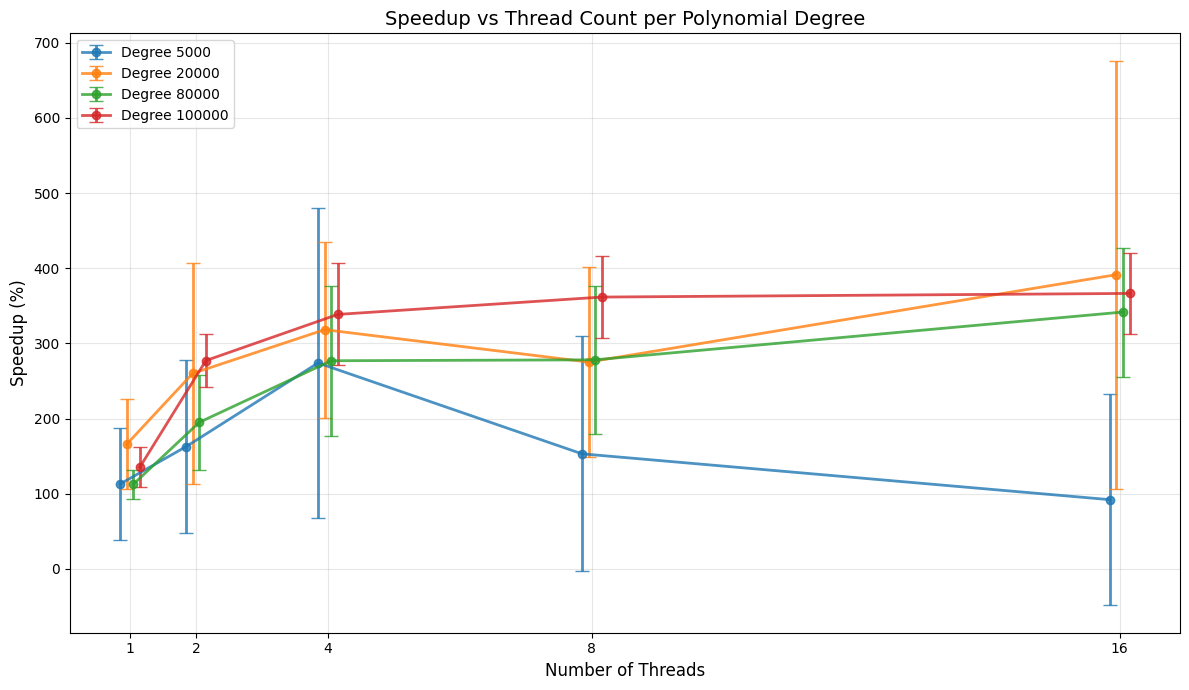


Speedup Statistics (Mean ± Std %):
 degree  threads   mean_pct    std_pct
   5000        1 112.909363  74.269428
   5000        2 162.650383 114.661936
   5000        4 273.967343 206.238953
   5000        8 153.067254 156.187149
   5000       16  92.051936 140.826152
  20000        1 165.813688  59.625264
  20000        2 260.053783 146.698044
  20000        4 318.298080 117.121799
  20000        8 275.173904 125.875744
  20000       16 391.477400 284.933403
  80000        1 112.543212  18.981371
  80000        2 194.984768  62.890062
  80000        4 276.923537  99.800966
  80000        8 278.160963  98.297779
  80000       16 341.756066  85.818468
 100000        1 135.452411  26.894666
 100000        2 277.170175  35.404166
 100000        4 338.596504  67.912100
 100000        8 361.675352  54.986350
 100000       16 366.522895  53.558930


In [28]:
# Calculate speedup (sequential time / parallel time)
speedup_data = []

for degree in res_1_df['degree'].unique():
    degree_data = res_1_df[res_1_df['degree'] == degree]
    seq_time = degree_data[degree_data['threads'] == 'sequential']['time_total'].values
    
    if len(seq_time) > 0:
        seq_time = seq_time[0]
        for _, row in degree_data[degree_data['threads'] != 'sequential'].iterrows():
            speedup = seq_time / row['time_total']
            speedup_data.append({
                'degree': degree,
                'threads': int(row['threads']),
                'speedup': speedup
            })

speedup_df = pd.DataFrame(speedup_data)

# Calculate mean and std for speedup across multiple runs
speedup_stats = speedup_df.groupby(['degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()

# Convert to percentage
speedup_stats['mean_pct'] = speedup_stats['mean'] * 100
speedup_stats['std_pct'] = speedup_stats['std'] * 100

# Plot speedup with error bars and jitter
fig, ax = plt.subplots(figsize=(12, 7))

# Define jitter offset for each degree
unique_degrees = sorted(speedup_stats['degree'].unique())
jitter_offset = np.linspace(-0.15, 0.15, len(unique_degrees))

for idx, degree in enumerate(unique_degrees):
    degree_stats = speedup_stats[speedup_stats['degree'] == degree].copy()
    # Add jitter to x positions
    x_jitter = degree_stats['threads'] + jitter_offset[idx]
    ax.errorbar(x_jitter, degree_stats['mean_pct'], 
                yerr=degree_stats['std_pct'], marker='o', label=f'Degree {int(degree)}', 
                linewidth=2, capsize=5, linestyle='-', alpha=0.8)

ax.set_xlabel('Number of Threads', fontsize=12)
ax.set_ylabel('Speedup (%)', fontsize=12)
ax.set_title('Speedup vs Thread Count per Polynomial Degree', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(sorted(speedup_stats['threads'].unique()))

plt.tight_layout()
plt.savefig('plots/speedup_per_degree.png', dpi=300)
plt.show()

print("\nSpeedup Statistics (Mean ± Std %):")
print(speedup_stats[['degree', 'threads', 'mean_pct', 'std_pct']].to_string(index=False))
